In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path

# Modelling Language Competition with Dynamical Systems

Gabriel Agostini, Gary Casey, and Teresa Brown

Code reference: https://github.com/TavoGLC/DataAnalysisByExample/tree/master/ParameterEstimation

November 18th, 2020

## 1. Data

We load the data for the $4$ cases we would like to test this model against. The data will be an $n\times 5$ dataframe whose columns are respectively the time array $T$, the total number of monolingual speakers of the preferred language $X_1$, the number of monolingual speakers of the minority language $X_2$, the number of bilingual speakers, and the total population at the given time. Full references are included in the repo.

(1) English vs. Welsh in Wales ($n=28$)

In [2]:
#NOTE that the data for 2002-2019 comes from a single source, and might disagree with the previous
# data. Those are rows of idx 10-27. I create new dataframes for each.

welsh_data = pd.read_csv(Path("data", "welsh.csv"))
welsh_data = welsh_data.astype('float64')
welsh_hist_data = welsh_data[:10]
welsh_new_data = welsh_data[10:]

(2) English vs. Spanish in the US ($n = ?$)

(3) English vs. French in Montreal ($n=5$)

In [3]:
canada_data = pd.read_csv(Path("data", "canada.csv"))
welsh_data = welsh_data.astype('float64')

## 2. Models

I use the odeint function in scipy.integrate with the Runge-Kutta order $4$ method. For parameter fitting, I use the curve_fit function in scipy.optimize.

In [4]:
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

Defining ODE solvers and fitting functions for each of the models, along with a function that, given the data, returns what we need to plot:

### 2.1. Abrams-Strogatz Model (2003)

The Abrams-Strogatz Model (2003) uses the following equation:

$$\dfrac{d x}{dt} = cs (1-x)x^a - c(1-s)x(1-x)^a$$

There are three parameters here, namely $c$, $a$ and $s$. For simplicity, as other authors do, I consider the parameter $c=1$. The equation for the second language will not be necessary as they are decoupled and $x_1 = 1 - x_2$.

In [5]:
def AS(data, AS_bestGuess, data_x_column=2, computeMSE=True):
    #First we do the modelling:
    def AS_Model(x, s, a):
        x = abs(x) #just in case we reachead below zero, since we are exponentiating
        y = abs(1-x)
        s_y = 1-s
        
        F = s*y*(x**a) - s_y*x*(y**a)
        return [F]
    
    #Pass the data as the dataframe, exactly as it was loaded in section 1
    def AS_preparedata(full_data, x_column=2):

        #First we get the datapoints column:
        select_data = full_data.values[:,x_column]
        
        #Normalize it:
        data = select_data/full_data.values[:,-1]

        #Get initial condition:
        IC = np.array([data[0]])

        #Formatting the time:
        raw_dataTime = full_data.values[:,0]
        t0 = raw_dataTime[0]
        tf = raw_dataTime[-1]

        dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
        SolverTime = np.linspace(0, 2030-t0+1) #Continuous-ish time to plot the solution fitted

        RealData = np.array([dataTime, data])
        return IC, data, dataTime, SolverTime, RealData

    #Model solver
    def AS_ModelSolver(IC, t, s, a):
        #It is more stable to pass to the odeint method a function without additional parameters:
        def LocalModel(t, X):
            return AS_Model(X, s, a)
        #Now we call the solver, since no method is specified this uses RK45
        Solution = solve_ivp(LocalModel, (t[0], t[-1]+1), IC, t_eval = t)
        #print(Solution.y)
        #print(Solution.y[0])
        return Solution.y[0]
    
    AS_IC, AS_data, AS_dataTime, AS_SolverTime, AS_RealData = AS_preparedata(data,
                                                                             x_column=data_x_column)

    #Now that we have the IC, we can define the function for the fit:
    def AS_ModelFit(t, s, a):
        return AS_ModelSolver(AS_IC, t, s, a)
    
    #print(AS_data)
    #print(AS_data.shape)
    #Now we do the fit:
    AS_bounds = (0, [1, np.inf])
    AS_Fit = curve_fit(AS_ModelFit, AS_dataTime, AS_data, p0=AS_bestGuess, method="trf", bounds=AS_bounds,
                      maxfev=50000)
    AS_bestParams = AS_Fit[0]
    
    #Using these parameters, we can run the model to get a "continuous" solution:
    AS_fitSolution = AS_ModelSolver(AS_IC, AS_SolverTime,
                                    AS_bestParams[0], AS_bestParams[1])
    AS_ModelData = np.array([AS_SolverTime, AS_fitSolution])
    
    #If we want, we can return the MSE:
    MSE = None
    if computeMSE == True:
        MSE = np.sum([(pred-real)**2 for pred,real in zip(AS_fitSolution, AS_data)])
    
    return AS_RealData, AS_ModelData, AS_bestParams, MSE

### 2.2. Zhang-Gong Model (2013)

The Zhang-Gong Model (2003) uses the following equations:

$$\begin{cases}
\dfrac{d x_1}{dt} = r_1x_1\left(1 - \dfrac{1}{N_1}x_1 - \dfrac{\sigma_1}{N_2}x_2\right)
\\
\dfrac{d x_2}{dt} = r_2x_2\left(1 - \dfrac{1}{N_2}x_2 - \dfrac{\sigma_2}{N_1}x_1\right)
\end{cases}$$

There are six parameters here, namely $r_1, r_2, N_1, N_2, \sigma_1, \sigma_2$.

To find the initial guess of the Zhang-Gong model, we can use their own techniques of estimation. To compute $r$ they use (when data is available), the language inheritance principle I:

$$r_1 = p(L_1) = p(L_1L_1) + \dfrac{1}{2}p(L_1L_2)\quad\text{and}\quad r_2 = p(L_2) = p(L_2L_2) + \dfrac{1}{2}p(L_1L_2)$$

Where $p(XY)$ is the relative proportion of speakers of the languages $X$ and $Y$ in the population.

In [6]:
#Take the array L to be a 1x3 array with the size of monol population for L1,
# for L2, and bilingual respectively
def R(L):
    tot = np.sum(L)
    p_11 = L[0]/tot
    p_22 = L[1]/tot
    p_12 = L[2]/tot
    
    return np.array([p_11 + 0.5*p_12, p_22 + 0.5*p_12])

Sigma can be estimated according to the language diffusion principle:

$$\sigma_1 = \dfrac{Q_2}{Q_1}\exp\left(\dfrac{d^2_1 - d^2_2}{4}\right)\quad\text{and}\quad
\sigma_2 = \dfrac{Q_1}{Q_2}\exp\left(\dfrac{d^2_2 - d^2_1}{4}\right)$$

Where $d_i$ is the distance of the population from the language center and $Q_i$ is the speaker population at the cultural center.

In [7]:
def Sigma(Q, D):
    if type(D) == type(None):
        D = np.zeros_like(Q)
    #print(D)
    #print(D.shape)
    sigma_1 = (Q[1]/(Q[0]+0.1))*math.exp((D[0]**2 - D[1]**2)/4)
    sigma_2 = (Q[0]/(Q[1]+0.1))*math.exp((D[1]**2 - D[0]**2)/4)
    return np.array([sigma_1, sigma_2])

The estimation for $N$ is simply the maximum population. We then get the best initial guess:

In [8]:
#NOTE: pass the data as the dataframe
def ZG_estimate(data, t0_idx=0, tf_idx=-1, D=None):
    data = data.values
    #Select the part of the data we will use based on the initial and final indices:
    if t0_idx != 0:
        data = data[t0_idx:]
    if tf_idx != -1:
        data = data[:tf_idx]
    #First we select the carrying capacity as max sum of monolingual speakers:
    N = np.max(np.add(data[:,1], data[:,2]))
    N_arr = np.array([N, N])
    #For the R parameters:
    L = np.array([data[0, 1], data[0, 2], data[0, 3]])
    r = R(L)
    #For the mutual influence, we use the distance provided (or None) and for Q we use the IC:
    Q = np.array([data[0, 1], data[0, 2]])
    #print(Q)
    sigma = Sigma(Q, D)
    return np.array([r[0], r[1], sigma[0], sigma[1], N_arr[0], N_arr[1]])

The following function summarizes all the above and performs the fit:

In [9]:
def ZG(data, data_x_column=2, ZG_bestGuess=None, computeMSE=True, D=None):
    #First we do the modelling:
    def ZG_Model(X, r_1, r_2, sigma_1, sigma_2, N_1, N_2):
        #print(X)
        F1 = r_1*X[0]*(1 - X[0]/N_1 - sigma_1*X[1]/N_2)
        F2 = r_2*X[1]*(1 - X[1]/N_2 - sigma_2*X[0]/N_1)
        return [F1, F2]
    
    #Pass the data as the dataframe, exactly as it was loaded in section 1
    def ZG_preparedata(full_data, x_column=2):

        #First we get the datapoints column:
        data = full_data.values[:,x_column]

        #Get initial condition:
        IC = np.array([full_data.values[0, 1], full_data.values[0, 2]])

        #Formatting the time:
        raw_dataTime = full_data.values[:,0]
        t0 = raw_dataTime[0]
        tf = raw_dataTime[-1]

        dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
        SolverTime = np.linspace(0, 2030-t0+1) #Continuous-ish time to plot the solution fitted

        RealData = np.array([dataTime, data])
        return IC, data, dataTime, SolverTime, RealData

    #Model solver
    def ZG_ModelSolver(IC, t, r_1, r_2, sigma_1, sigma_2, N_1, N_2, sol=1):
        #It is more stable to pass to the odeint method a function without additional parameters:
        def LocalModel(t, X):
            return ZG_Model(X, r_1, r_2, sigma_1, sigma_2, N_1, N_2)
        #Now we call the solver, since no method is specified this uses RK45
        #print(IC)
        #print(IC.shape)
        Solution = solve_ivp(LocalModel, (t[0], t[-1]+1), IC, t_eval = t)
        #print(Solution.y[sol])
        #print(Solution.y[sol].shape)
        return Solution.y[sol]
    
    ZG_IC, ZG_data, ZG_dataTime, ZG_SolverTime, ZG_RealData = ZG_preparedata(data,
                                                                             x_column=data_x_column)

    #Now that we have the IC, we can define the function for the fit:
    def ZG_ModelFit(t, r_1, r_2, sigma_1, sigma_2, N_1, N_2):
        return ZG_ModelSolver(ZG_IC, t, r_1, r_2, sigma_1, sigma_2, N_1, N_2)
    
    #If we are not given an initial guess, we must find it:
    if type(ZG_bestGuess) == type(None):
        ZG_bestGuess = ZG_estimate(data, D=D)
    
    #print(ZG_data)
    #print(ZG_data.shape)
    #Now we do the fit:
    ZG_bounds = (0, [1, 1, np.inf, np.inf, np.inf, np.inf])
    ZG_Fit = curve_fit(ZG_ModelFit, ZG_dataTime, ZG_data, p0=ZG_bestGuess,
                       bounds=ZG_bounds, method="trf", maxfev=50000)
    ZG_bestParams = ZG_Fit[0]
    
    #Using these parameters, we can run the model to get a "continuous" solution:
    ZG_fitSolution = ZG_ModelSolver(ZG_IC, ZG_SolverTime,
                                    ZG_bestParams[0], ZG_bestParams[1], ZG_bestParams[2],
                                    ZG_bestParams[3], ZG_bestParams[4], ZG_bestParams[5])
    ZG_ModelData = np.array([ZG_SolverTime, ZG_fitSolution])
    
    #If we want, we can return the MSE:
    MSE = None
    if computeMSE == True:
        MSE = np.sum([(pred-real)**2 for pred,real in zip(ZG_fitSolution, ZG_data)])
    
    return ZG_RealData, ZG_ModelData, ZG_bestParams, MSE

### 2.3. Luck-Mehta Model (2020)

The Luck-Mehta Model (2020) uses the following equations:

$$\begin{cases}
\dfrac{d x_1}{dt} = x_1\left(1 - x_1 - qx_2 + Cx_2\right)
\\
\dfrac{d x_2}{dt} = x_2\left(1 - x_2 - qx_1 - Cx_1\right)
\end{cases}$$

There are two parameters here, namely $c$ and $q$.

In [10]:
def LM(data, data_x_column=2, LM_bestGuess=None, computeMSE=True, D=None):
    #First we do the modelling:
    def LM_Model(X, q, C):
        #print(X)
        F1 = X[0]*(1 - X[0] - q*X[1] + C*X[1])
        F2 = X[1]*(1 - X[1] - q*X[0] - C*X[0])
        return [F1, F2]
    
    #Pass the data as the dataframe, exactly as it was loaded in section 1
    def LM_preparedata(full_data, x_column=2):

        #First we get the datapoints column:
        select_data = full_data.values[:,x_column]
    
        #Normalize it:
        data = select_data/full_data.values[:,-1]
        
        #Get initial condition:
        IC = np.array([1 - data[0], data[0]])

        #Formatting the time:
        raw_dataTime = full_data.values[:,0]
        t0 = raw_dataTime[0]
        tf = raw_dataTime[-1]

        dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
        SolverTime = np.linspace(0, 2030-t0+1) #Continuous-ish time to plot the solution fitted

        RealData = np.array([dataTime, data])
        return IC, data, dataTime, SolverTime, RealData

    #Model solver
    def LM_ModelSolver(IC, t, q, C, sol=1):
        #It is more stable to pass to the odeint method a function without additional parameters:
        def LocalModel(t, X):
            return LM_Model(X, q, C)
        #Now we call the solver, since no method is specified this uses RK45
        #print(IC)
        #print(IC.shape)
        Solution = solve_ivp(LocalModel, (t[0], t[-1]+1), IC, t_eval = t)
        #print(Solution.y[sol])
        #print(Solution.y[sol].shape)
        return Solution.y[sol]
    
    LM_IC, LM_data, LM_dataTime, LM_SolverTime, LM_RealData = LM_preparedata(data,
                                                                             x_column=data_x_column)

    #Now that we have the IC, we can define the function for the fit:
    def LM_ModelFit(t, q, C):
        return LM_ModelSolver(LM_IC, t, q, C)
    
    #If we are not given an initial guess, we must find it:
    if type(LM_bestGuess) == type(None):
        LM_bestGuess = LM_estimate(data)
    
    #print(ZG_data)
    #print(ZG_data.shape)
    #Now we do the fit:
    LM_bounds = (0, [np.inf, np.inf])
    LM_Fit = curve_fit(LM_ModelFit, LM_dataTime, LM_data, p0=LM_bestGuess,
                       bounds=LM_bounds, method="trf", maxfev=50000)
    LM_bestParams = LM_Fit[0]
    
    #Using these parameters, we can run the model to get a "continuous" solution:
    LM_fitSolution = LM_ModelSolver(LM_IC, LM_SolverTime,
                                    LM_bestParams[0], LM_bestParams[1])
    LM_ModelData = np.array([LM_SolverTime, LM_fitSolution])
    
    #If we want, we can return the MSE:
    MSE = None
    if computeMSE == True:
        MSE = np.sum([(pred-real)**2 for pred,real in zip(LM_fitSolution, LM_data)])
    
    return LM_RealData, LM_ModelData, LM_bestParams, MSE

## 3. Simulation

Plotting function:

In [11]:
#Here, the data should be a 2 x n array where the first column is the corresponding time point.
# The RealData will be plotted in a scatter fashion, whereas the ModelData in a continuous fashion.
def Plot_FittedSolution(Fig, RealData, ModelData, t0=0, ymin=None,
                        axes_labels=["Year", "Monolingual Speakers"], title=" "):
    ax = Fig.gca()
    
    #First we plot the real data:
    x_arr = RealData[0] + t0
    y_arr = RealData[1]
    ax.scatter(x_arr, y_arr, marker="x", color="r")
    
    #The regression data:
    x_arr2 = ModelData[0] +t0
    y_arr2 = ModelData[1]
    ax.plot(x_arr2, y_arr2)
    
    #Now we configure the plot to look nice and add the labels:
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlabel(axes_labels[0],fontsize=16)
    if type(ymin) != type(None):
        ax.set_ylim(bottom=ymin)
    ax.set_ylabel(axes_labels[1],fontsize=16)
    ax.set_title(title, fontsize=24)
    
    
    return Fig

### 3.1. Welsh vs. English:

#### a. Abrams-Strogatz:

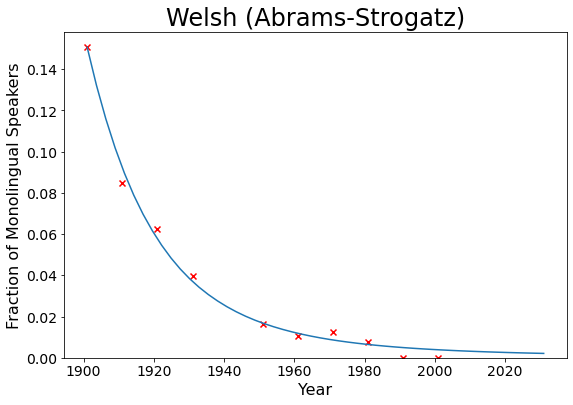

In [12]:
AS_bestGuess = [0.5, 1]

welsh_AS_RealData, welsh_AS_ModelData, welsh_AS_bestParams, welsh_AS_MSE = AS(welsh_hist_data, AS_bestGuess=AS_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh_AS_RealData, welsh_AS_ModelData,
                           t0=1901, ymin=0,
                           axes_labels=["Year", "Fraction of Monolingual Speakers"], title="Welsh (Abrams-Strogatz)")

Is this similar to what we expected?

In [13]:
welsh_AS_bestParams

array([0.46349912, 0.98160148])

#### b. Zhang-Gong:

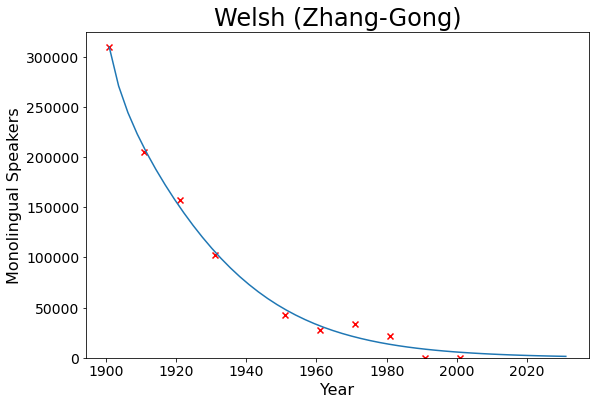

In [14]:
welsh_ZG_RealData, welsh_ZG_ModelData, welsh_ZG_bestParams, welsh_ZG_MSE = ZG(welsh_hist_data)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh_ZG_RealData, welsh_ZG_ModelData,
                           ymin=0, t0=1901, title="Welsh (Zhang-Gong)")

How do the parameters compare?

In [15]:
welsh_ZG_bestParams

array([2.60881886e-01, 2.13607943e-02, 2.64977303e+00, 3.11420891e+00,
       8.63629193e+05, 2.34990890e+06])

#### c. Luck-Mehta

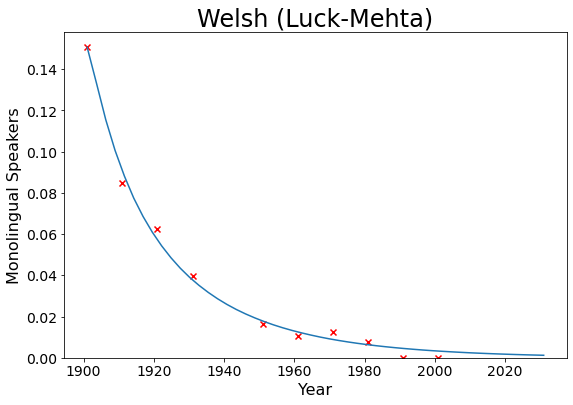

In [16]:
LM_bestGuess = [0.5, 1]

welsh_LM_RealData, welsh_LM_ModelData, welsh_LM_bestParams, welsh_LM_MSE = LM(welsh_hist_data, LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh_LM_RealData, welsh_LM_ModelData,
                           ymin=0, t0=1901, title="Welsh (Luck-Mehta)")

In [17]:
np.sum(welsh_LM_bestParams)

1.032204774477461

### 3.3. French vs. English (Montreal)

#### a. Abrams-Strogatz

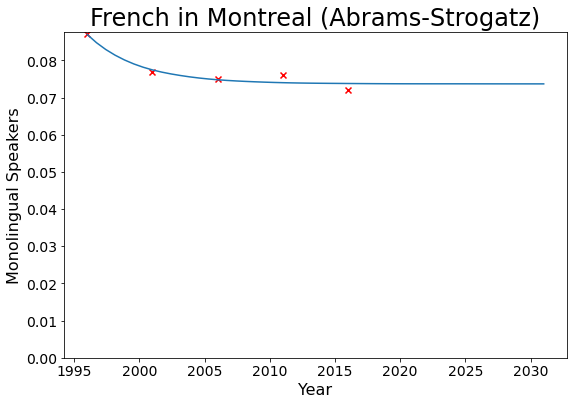

In [18]:
canada_AS_RealData, canada_AS_ModelData, canada_AS_bestParams, canada_AS_MSE = AS(canada_data, AS_bestGuess=AS_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada_AS_RealData, canada_AS_ModelData,
                           ymin=0, t0=1996, title="French in Montreal (Abrams-Strogatz)")

zooming in:

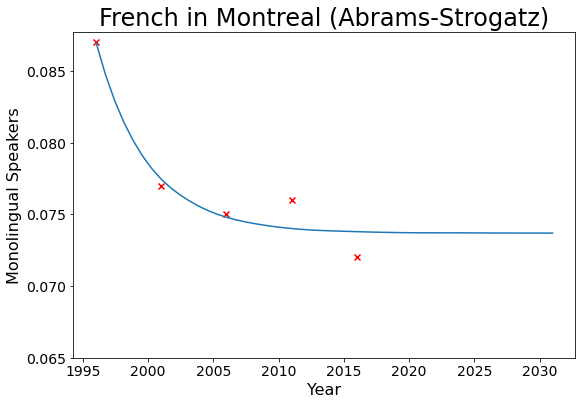

In [19]:
fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada_AS_RealData, canada_AS_ModelData,
                           ymin=0.065, t0=1996, title="French in Montreal (Abrams-Strogatz)")

Why does this happen?

In [20]:
canada_AS_bestParams

array([0.2977158 , 0.66096534])

#### b. Zhang-Gong

/Users/gsagostini/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


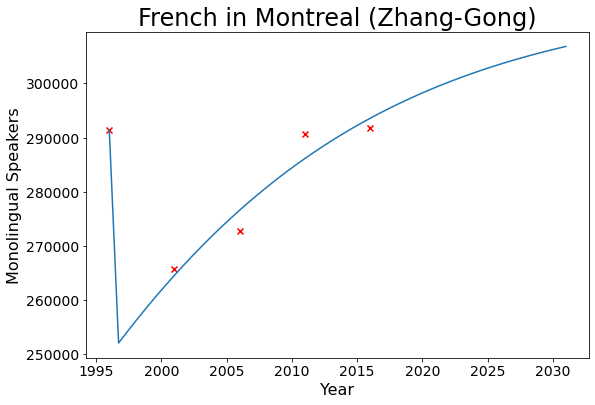

In [21]:
canada_ZG_RealData, canada_ZG_ModelData, canada_ZG_bestParams, canada_ZG_MSE = ZG(canada_data)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada_ZG_RealData, canada_ZG_ModelData,
                           t0=1996, title="French in Montreal (Zhang-Gong)")

In [22]:
canada_ZG_bestParams

array([1.56389803e-01, 6.20219214e-02, 1.42626762e+02, 6.10102343e+01,
       1.76295961e+06, 3.16133466e+05])

What if we use their estimation?

In [23]:
ZG_bestGuess = ZG_estimate(canada_data)
r_1, r_2, sigma_1, sigma_2, N_1, N_2 = ZG_bestGuess

IC = np.array([canada_data.values[0, 1], canada_data.values[0, 2]])
#print(IC)
SolverTime = np.linspace(0, 2030-canada_data.values[:,0][0]+1)

def ZG_Model2(t, X):
    #print(X)
    F1 = r_1*X[0]*(1 - X[0]/N_1 - sigma_1*X[1]/N_2)
    F2 = r_2*X[1]*(1 - X[1]/N_2 - sigma_2*X[0]/N_1)
    return [F1, F2]

y = solve_ivp(ZG_Model2, (SolverTime[0], SolverTime[-1]+1), IC, t_eval = SolverTime).y[1]

canada_ZG_ModelData2 = np.array([SolverTime, y])

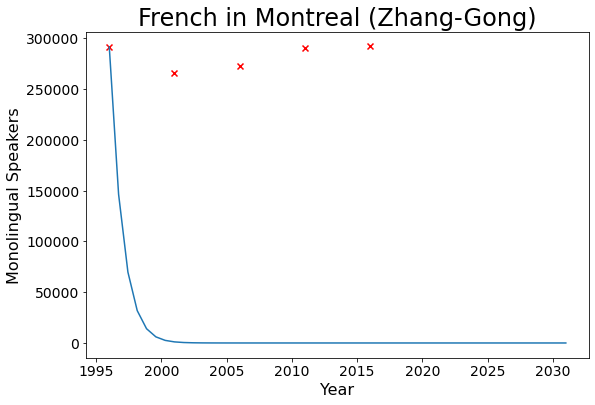

In [24]:
fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada_ZG_RealData, canada_ZG_ModelData2,
                           t0=1996, title="French in Montreal (Zhang-Gong)")

Distance from cultural center?

#### c. Luck-Mehta

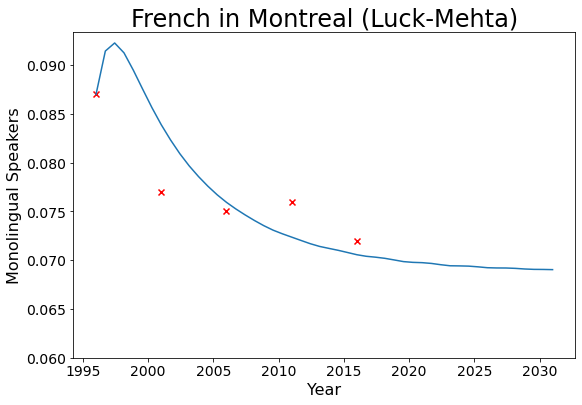

In [25]:
LM_bestGuess = [0.5, 1]

canada_LM_RealData, canada_LM_ModelData, canada_LM_bestParams, canada_LM_MSE = LM(canada_data, LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada_LM_RealData, canada_LM_ModelData,
                           ymin=0.06, t0=1996, title="French in Montreal (Luck-Mehta)")

In [26]:
canada_LM_bestParams

array([1.20991207e-19, 8.78169426e-01])

In [27]:
np.sum(canada_LM_bestParams)

0.8781694259263249

In [28]:
q_opt, C_opt = canada_LM_bestParams[0], canada_LM_bestParams[1]
eq = (1-q_opt-C_opt)/(1-q_opt**2 + C_opt**2)

In [29]:
eq

0.06878491632778583